In [2]:
import numpy as np
from iminuit import Minuit

import constants, functions

from functools import partial

from joblib import Parallel, delayed

from matplotlib import pyplot as plt
from matplotlib.patches import Patch

In [9]:
z_data = np.asarray(constants.z_data)
fs8_data = np.asarray(constants.fs8_data)
fs8_err_plus = np.asarray(constants.fs8_err_plus)
fs8_err_minus = np.asarray(constants.fs8_err_minus)

z_data_panth = np.asarray(constants.z_data_panth)
is_calibrator_panth = np.asarray(constants.is_calibrator_panth)
m_b_corr_panth = np.asarray(constants.m_b_corr_panth)
ceph_dist_panth = np.asarray(constants.ceph_dist_panth)
inv_cov_panth = np.asarray(constants.inv_cov_panth)
n_panth = constants.n_panth
c = constants.C

chi2_func = partial(
    functions.chi2_rsd_panth,
    z_data,
    fs8_data,
    fs8_err_plus,
    fs8_err_minus,
    n_panth,
    z_data_panth,
    is_calibrator_panth,
    m_b_corr_panth,
    ceph_dist_panth,
    inv_cov_panth
)

# def chi2_rsd_panth(omega, sigma, gamma, H0, M):
#     return functions.chi2_rsd_panth(constants.z_data, constants.fs8_data.values, constants.fs8_err_plus, constants.fs8_err_minus, constants.n_panth, constants.z_data_panth, constants.is_calibrator_panth, constants.m_b_corr_panth, constants.ceph_dist_panth, constants.inv_cov_panth, omega, sigma, gamma, H0, M)

n_om = 100
om_min = .05
om_max = 1

n_s8 = 100
s8_min = 0.4
s8_max = 1.2

n_gamma = 100
gamma_min = -0.5
gamma_max = 2

omega_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))

minimizer = Minuit(chi2_func, omega=0.315, sigma=0.811, gamma=0.55, H0 = 73.4, M=-19.25, c=constants.C)

minimizer.limits["omega"] = (om_min,om_max)
minimizer.limits["sigma"] = (s8_min,s8_max)
minimizer.limits["gamma"] = (gamma_min,gamma_max)
minimizer.fixed["H0"] = True
minimizer.fixed["M"] = True
minimizer.fixed["c"] = True

result = minimizer.migrad()

In [7]:
print(f"\nRésultats du fit :")
print(f"Chi2 = {minimizer.fval:.2f} \n")
print(f"Paramètres estimés :")
print(f"Ωm = {minimizer.values['omega']:.10f} ± {minimizer.errors['omega']:.10f}")
print(f"σ8,0 = {minimizer.values['sigma']:.10f} ± {minimizer.errors['sigma']:.10f}")
print(f"γ = {minimizer.values['gamma']:.10f} ± {minimizer.errors['gamma']:.10f}\n")
print(f"H0 = {minimizer.values['H0']:.10f} ± {minimizer.errors['H0']:.10f}")
print(f"M = {minimizer.values['M']:.10f} ± {minimizer.errors['M']:.10f}")

print(result)


Résultats du fit :
Chi2 = 1598.06 

Paramètres estimés :
Ωm = 0.3159400556 ± 0.0094539970
σ8,0 = 0.7436796816 ± 0.0480996234
γ = 0.4773591151 ± 0.1105421060

H0 = 73.4000000000 ± 0.7340000000
M = -19.2500000000 ± 0.1925000000
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1598                       │              Nfcn = 69               │
│ EDM = 6.29e-07 (Goal: 0.0002)    │            time = 2.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│            

chi2 théorie        : 14.999544577468223
chi2 RSD seul       : 8.055740706979694
chi2 RSD + Pantheon : 9.97229829420518


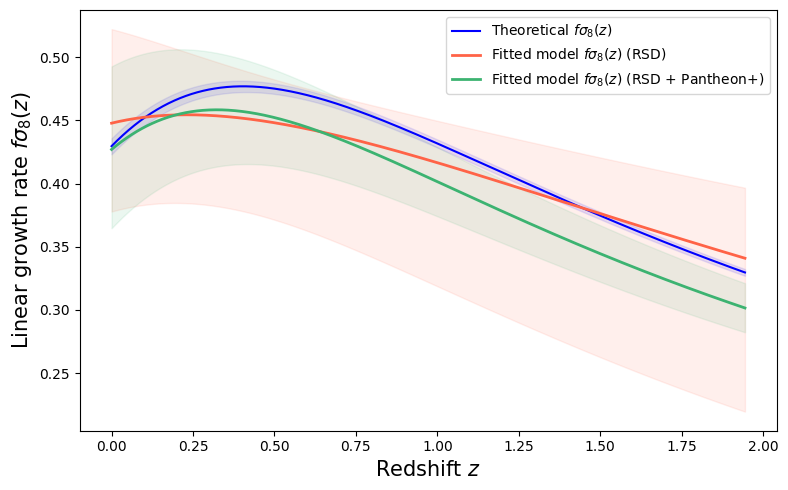

In [4]:
from scipy.stats import chi2
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

################################ Number of points for theoretical growth function plot
nb_points_th = 1000
z_range = np.linspace(min(constants.z_data), max(constants.z_data), nb_points_th)

################################ Bootstrap

### Theoretical
nb_draw = 1000
fsigma8_results_boot = np.zeros((nb_draw, nb_points_th))

for i in range(nb_draw):
    omega0 = np.random.normal(constants.OMEGA_0, constants.OMEGA_0_SIGMA)
    sigma8_0 = np.random.normal(constants.SIGMA_8_0, constants.SIGMA_8_0_SIGMA)
    fsigma8_results_boot[i, :] = functions.growth(z_range, omega_0 = omega0, sigma_8_0 = sigma8_0)

fsigma8_mean, fsigma8_std = np.mean(fsigma8_results_boot, axis=0), np.std(fsigma8_results_boot, axis=0)

### RSD
fsigma8_rsd_boot = np.zeros((nb_draw, nb_points_th))

for i in range(nb_draw):
    omega0 = np.random.normal(0.050, 0.1162)
    while omega0 < 0:
        omega0 = np.random.normal(0.050, 0.1162)
    sigma8_0 = np.random.normal(0.536, 0.0553)
    gamma = np.random.normal(0.060, 0.051)
    while gamma < 0:
        gamma = np.random.normal(0.060, 0.051)
    fsigma8_rsd_boot[i, :] = functions.growth(z_range, omega_0=omega0, sigma_8_0=sigma8_0, gamma=gamma)

fsigma8_rsd_mean, fsigma8_rsd_std = np.mean(fsigma8_rsd_boot, axis=0), np.std(fsigma8_rsd_boot, axis=0)

### RSD + Pantheon+
fsigma8_rsd_panth_boot = np.zeros((nb_draw, nb_points_th))

for i in range(nb_draw):
    omega0 = np.random.normal(0.352, 0.0185702486)
    sigma8_0 = np.random.normal(0.755, 0.0477977060)
    gamma = np.random.normal(0.546, 0.1257045177)
    fsigma8_rsd_panth_boot[i, :] = functions.growth(z_range, omega_0=omega0, sigma_8_0=sigma8_0, gamma=gamma)

fsigma8_rsd_panth_mean, fsigma8_rsd_panth_std = np.mean(fsigma8_rsd_panth_boot, axis=0), np.std(fsigma8_rsd_panth_boot, axis=0)

################################ Approximation

fs8_approx_rsd = functions.growth(z_range, gamma=0.060, omega_0=0.050, sigma_8_0=0.536)
fs8_approx_rsd_panth = functions.growth(z_range, gamma=0.5464512238, omega_0=0.3527096773, sigma_8_0=0.7546689729)

################################ Plotting

plt.figure(figsize=(8, 5))

def chi2_abs(z_data, data, fs8_err_asym, model_func):
    # Calculer les erreurs symétriques moyennes
    err = 0.5 * (np.array(fs8_err_asym[0]) + np.array(fs8_err_asym[1]))

    model_vals = model_func(z_data)
    model_vals = np.asarray(model_vals)

    if model_vals.shape != data.shape:
        raise ValueError(f"Incompatible shapes: model {model_vals.shape} vs data {data.shape}")

    residuals = (data - model_vals) / err
    return np.sum(residuals**2)



growth_values = functions.growth(z_range)
plt.plot(z_range, growth_values, color='blue', label=r"Theoretical $f\sigma_8(z)$")
plt.fill_between(z_range, fsigma8_mean-fsigma8_std,
                            fsigma8_mean+fsigma8_std,
                color='blue', alpha=0.1)

plt.plot(z_range, fs8_approx_rsd, color='tomato', lw=2, label=r"Fitted model $f\sigma_8(z)$ (RSD)")
plt.fill_between(z_range, fsigma8_rsd_mean - fsigma8_rsd_std,
                             fsigma8_rsd_mean + fsigma8_rsd_std,
                 color='tomato', alpha=0.1)

plt.plot(z_range, fs8_approx_rsd_panth, color='mediumseagreen', lw=2, label=r"Fitted model $f\sigma_8(z)$ (RSD + Pantheon+)")
plt.fill_between(z_range, fsigma8_rsd_panth_mean - fsigma8_rsd_panth_std,
                             fsigma8_rsd_panth_mean + fsigma8_rsd_panth_std,
                 color='mediumseagreen', alpha=0.1)

# Labels
plt.xlabel("Redshift $z$", fontsize=15)
plt.ylabel(r"Linear growth rate $f\sigma_8(z)$", fontsize=15)
plt.grid(False)
plt.legend()
plt.tight_layout()

chi2_theory = chi2_abs(constants.z_data, constants.fs8_data, constants.fs8_err, functions.growth)
chi2_rsd = chi2_abs(constants.z_data, constants.fs8_data, constants.fs8_err,
                lambda x: functions.growth(x, gamma=0.060, omega_0=0.050, sigma_8_0=0.536))
chi2_rsd_panth = chi2_abs(constants.z_data, constants.fs8_data, constants.fs8_err,
                lambda x: functions.growth(x, gamma=0.546, omega_0=0.352, sigma_8_0=0.755))
print("chi2 théorie        :", chi2_theory)
print("chi2 RSD seul       :", chi2_rsd)
print("chi2 RSD + Pantheon :", chi2_rsd_panth)

plt.show()

In [ ]:
from time import time

### A run sans avoir run le précédent bloc.

def chi2_om_s8_func(omega, sigma, gamma_min, gamma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, sigma=sigma, gamma=0.55, H0 = 73.4, M=-19.25, c=constants.C)
    minimizer.fixed["omega"] = True
    minimizer.fixed["sigma"] = True
    minimizer.limits["gamma"] = (gamma_min, gamma_max)
    minimizer.limits["H0"] = (0, 200)
    minimizer.fixed["M"] = True
    minimizer.fixed["c"] = True
    minimizer.migrad()
    return minimizer.fval

def chi2_om_gamma_func(omega, gamma, sigma_min, sigma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, gamma=gamma, sigma=0.7, H0 = 73.4, M=-19.25, c=constants.C)
    minimizer.fixed["omega"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["sigma"] = (sigma_min, sigma_max)
    minimizer.limits["H0"] = (0, 200)
    minimizer.fixed["M"] = True
    minimizer.fixed["c"] = True
    minimizer.migrad()
    return minimizer.fval

def chi2_s8_gamma_func(sigma, gamma, omega_min, omega_max, chi2_func):
    minimizer = Minuit(chi2_func, sigma=sigma, gamma=gamma, omega=0.3, H0 = 73.4, M=-19.25, c=constants.C)
    minimizer.fixed["sigma"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["omega"] = (omega_min, omega_max)
    minimizer.limits["H0"] = (0, 200)
    minimizer.fixed["M"] = True
    minimizer.fixed["c"] = True
    minimizer.migrad()
    return minimizer.fval

t = time()
chi2_om_sig8 = Parallel(n_jobs=-1)(delayed(chi2_om_s8_func)(omega, sigma, gamma_min, gamma_max, chi2_func) for omega in omega_vals for sigma in sigma_vals)
chi2_grid1 = np.array(chi2_om_sig8).reshape(n_om, n_s8)
np.savez("../output/chi2_SN1a/chi2_grid1_fast.npz", grid1=chi2_grid1)
t = time() - t
print("chi2_grids calculated in", int(t//60), "min", round(t%60,1), "s.")


chi2_grid2 = np.zeros((n_om, n_gamma))
chi2_grid3 = np.zeros((n_s8, n_gamma))

chi2_grids calculated in 2 min 27.6 s.


In [11]:
chi2_grid1_loaded = chi2_grid1
print(chi2_grid1.shape)

(100, 100)


In [11]:
n_om = 10
om_min = .05
om_max = 1

n_s8 = 10
s8_min = 0.4
s8_max = 1.2

n_gamma = 10
gamma_min = -0.5
gamma_max = 2

omega_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))

# chi2_grid1_loaded = chi2_grid1

chi2_grid1_loaded = np.load("../output/chi2_SN1a/chi2_grid1_fast.npz")['grid1']
chi2_grid2 = np.zeros((n_om, n_gamma))
chi2_grid3 = np.zeros((n_s8, n_gamma))

print(chi2_grid1_loaded)
print(chi2_grid1_loaded.shape)

[[2053.64349787 2046.81340114 2046.57585572 2050.63331258 2057.62730519
  2066.70082821 2077.28573232 2088.99152203 2101.54076062 2114.73168731]
 [1785.84939924 1760.80314    1748.59176623 1745.03197001 1747.55193686
  1754.47494662 1764.65871752 1777.2981338  1791.81013652 1807.76308694]
 [1688.64076603 1651.29783385 1630.63407374 1621.40684276 1620.32186187
  1625.19051445 1634.49820374 1647.16234001 1662.38965006 1679.58691093]
 [1685.0117008  1638.15045284 1610.82172613 1596.98256695 1592.83208325
  1595.81292116 1604.13530464 1616.50809433 1631.97753934 1649.82548533]
 [1756.76567202 1685.84283962 1653.00374448 1635.27028089 1628.45674629
  1629.71930128 1637.05120157 1648.99528928 1664.46873984 1683.26032224]
 [1879.06416008 1774.64026198 1737.1067274  1716.00505756 1706.842096
  1706.54033863 1712.91485899 1727.16121515 1772.93988831 1855.91286523]
 [2029.86071463 1896.39672775 1850.71695787 1826.65010647 1815.38815015
  1813.65748213 1838.70444238 1911.95841817 2033.43944219 22

Incertitude $\sigma_8$ : xmin = 0.69, xmax = 0.83 : (+0.06, -0.07)
Incertitude $\Omega_m$ : ymin = 0.33, ymax = 0.38 : (+0.03, -0.02)

Incertitude $\gamma$ : xmin = -0.50, xmax = 2.00 : (+0.0, -2.5)
Incertitude $\Omega_m$ : ymin = 0.05, ymax = 1.00 : (+0.0, -0.95)

Incertitude $\gamma$ : xmin = -0.50, xmax = 2.00 : (+0.0, -2.5)
Incertitude $\sigma_8$ : ymin = 0.40, ymax = 1.20 : (+0.0, -0.8)



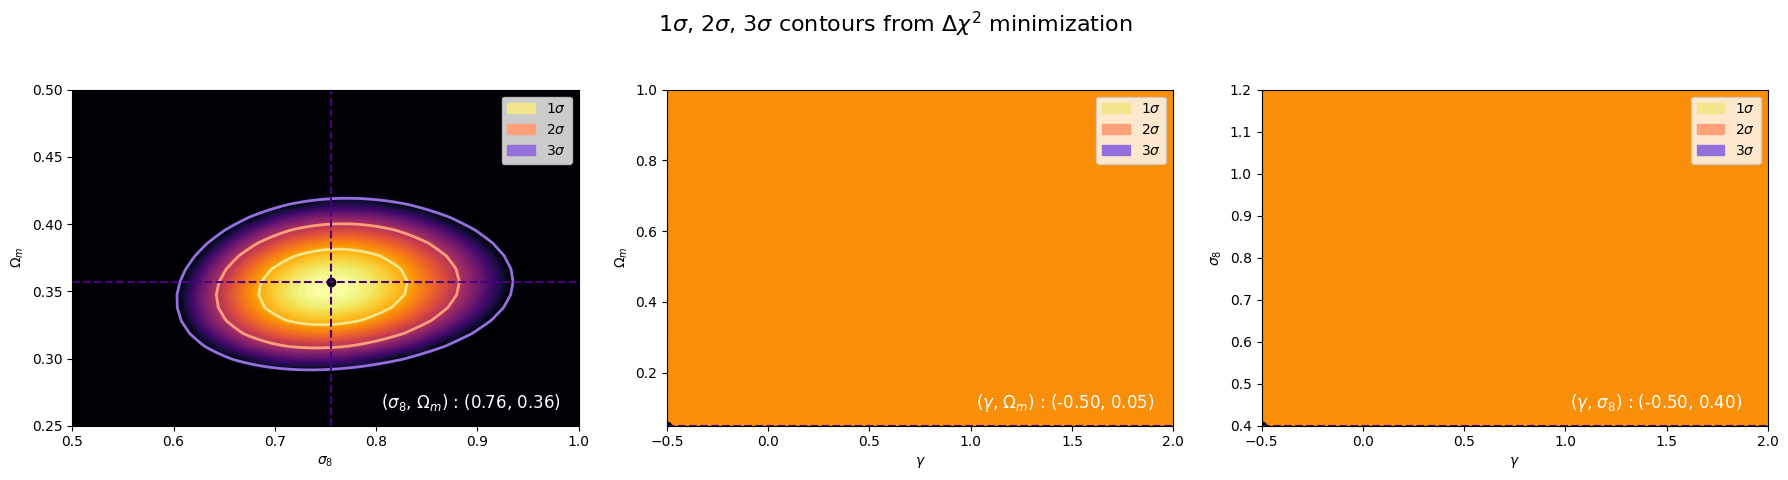

In [12]:
def display_all_chi2(chi2_grids, axes):
    levels = [2.3, 6.17, 11.8]
    colors = ['khaki', 'lightsalmon', 'mediumpurple']

    axes_titles = [
        (r'$\sigma_8$', r'$\Omega_m$', 0),
        (r'$\gamma$', r'$\Omega_m$', 1),
        (r'$\gamma$', r'$\sigma_8$', 2)
    ]

    for ax, (xlabel, ylabel, axis) in zip(axes, axes_titles):
        chi2_grid = chi2_grids[axis]
        if axis == 0:
            X, Y = np.meshgrid(sigma_vals, omega_vals)
        elif axis == 1:
            X, Y = np.meshgrid(gamma_vals, omega_vals)
        elif axis == 2:
            X, Y = np.meshgrid(gamma_vals, sigma_vals)

        chi2_min = np.min(chi2_grid)
        delta_chi2 = chi2_grid - chi2_min

        delta_chi2_clipped = np.clip(delta_chi2, a_min=None, a_max=levels[2])
        
        cf = ax.contourf(X, Y, delta_chi2_clipped, levels=100, cmap='inferno_r')
        for level, color in zip(levels, colors):
            cs = ax.contour(X, Y, delta_chi2, levels=[level], colors=[color], linewidths=2)

            # Get incertitude
            if level == 2.3:
                mask = delta_chi2 <= level

                x_coords = X[mask]
                y_coords = Y[mask]

                xmin, xmax = np.min(x_coords), np.max(x_coords)
                ymin, ymax = np.min(y_coords), np.max(y_coords)

        legend_handles = [
            Patch(color='khaki', label=r'$1\sigma$'),
            Patch(color='lightsalmon', label=r'$2\sigma$'),
            Patch(color='mediumpurple', label=r'$3\sigma$')
        ]
        ax.legend(handles=legend_handles, loc='upper right')

        min_idx = np.unravel_index(np.argmin(delta_chi2), delta_chi2.shape)
        x_min = X[min_idx]
        y_min = Y[min_idx]
        ax.plot(x_min, y_min, 'ko', label='Best-fit')
        ax.axhline(y_min, color='indigo', linestyle='--')
        ax.axvline(x_min, color='indigo', linestyle='--')

        print(f"Incertitude {axes_titles[axis][0]} : xmin = {xmin:.2f}, xmax = {xmax:.2f} : (+{round(x_min - xmin, 2)}, -{round(xmax - x_min, 2)})")
        print(f"Incertitude {axes_titles[axis][1]} : ymin = {ymin:.2f}, ymax = {ymax:.2f} : (+{round(y_min - ymin, 2)}, -{round(ymax - y_min, 2)})\n")

        latex_text = fr"({xlabel}, {ylabel}) : ({x_min:.2f}, {y_min:.2f})"
        ax.text(0.61, 0.1, latex_text, transform=ax.transAxes, color="white", fontsize=12,
                verticalalignment='top', horizontalalignment='left')

        ax.set_xlabel(axes_titles[axis][0])
        ax.set_ylabel(axes_titles[axis][1])

        if axis == 0:
            ax.set_xlim([0.5, 1])
            ax.set_ylim([0.25, 0.5])
        elif axis == 1:
            # ax.set_xlim([0.2, 1.2])
            # ax.set_ylim([0.1, 0.6])
            pass
        elif axis == 2:
            pass
            # ax.set_xlim([0.2, 1.4])
            # ax.set_ylim([0.4, 0.8])


fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(r"1$\sigma$, 2$\sigma$, 3$\sigma$ contours from $\Delta \chi^2$ minimization", fontsize=16)
display_all_chi2([chi2_grid1_loaded, chi2_grid2, chi2_grid3], axes)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
